In [109]:
import pandas as pd
import matplotlib.pyplot as plt

harrisP1 = pd.read_csv("data/HarrisPartI.csv")
harrisP3 = pd.read_csv("data/HarrisPartIII.csv")
Krause = pd.read_csv("data/Krause21.csv")
VandenBerg = pd.read_csv("data/vandenBerg_table2.csv")

def norm_ids(series):
    return series.dropna().astype(str).str.replace(r"\s+","",regex=True).str.upper()

kraus_ids=set(norm_ids(Krause["Object"]))
#VandenBerg_ids=set('NGC'+norm_ids(VandenBerg["#NGC"]))

VandenBerg.iloc[:,0] = "NGC" + VandenBerg.iloc[:,0].astype(str)
#print(VandenBerg.iloc[:,0] )
#print(Krause.iloc[:,1] )

#union_ids = kraus_ids | VandenBerg_ids
#uncommon_ids = kraus_ids ^ VandenBerg_ids
#print (len(union_ids))
#print(union_ids)

list_accreted = ['Arp2' ,'NGC5024' ,'Crater' ,'IC4499', 'Pal4' ,'NGC5694' ,'NGC2298', 'NGC4147',
 'Pal14' ,'NGC7089' ,'NGC5272', 'NGC6934', 'NGC6101', 'NGC5466', 'Pal5' ,'Pal15',
 'Pal13' ,'NGC5053', 'NGC6715', 'Pal2', 'NGC1261', 'Whiting1' ,'NGC5634',
 'NGC7492', 'Terzan7', 'NGC5904' ,'IC1257', 'NGC2419' ,'NGC7006' ,'NGC6584',
 'NGC3201' ,'NGC6229' ,'Pyxis', 'NGC1904', 'NGC1851', 'NGCTer8', 'NGC6981' ,'E1',
 'NGC6864', 'Eridanus' ,'AM4', 'FSR1758']
set_accreted = set(list_accreted)

#int_accreted = set_accreted & union_ids
#print(uncommon_ids&int_accreted)
#print(set_accreted)
#print(union_ids)
#print(int_accreted)
#print(len(int_accreted))

Krause_filtered = Krause[Krause["Object"].isin(set_accreted)]
VandenBerg_filtered = VandenBerg[VandenBerg["#NGC"].isin(set_accreted)]
#print(VandenBerg)

VandenBerg_filtered= VandenBerg_filtered.rename(columns={"#NGC":"ID"})
#print(VandenBerg_filtered)

union_GCs= pd.concat([Krause_filtered, VandenBerg_filtered], ignore_index=True)
#print(len(VandenBerg_filtered))
#print(len(Krause_filtered))

Accreted = pd.merge(Krause_filtered, VandenBerg_filtered, left_on="Object", right_on="ID", how="outer",  suffixes=("_K", "_V"))
Union = pd.merge(Krause, VandenBerg, left_on="Object", right_on="#NGC", how="outer",  suffixes=("_K", "_V"))

Accreted["Age"] = Accreted["Age_V"].combine_first(Accreted["Age_K"])
Accreted["FeH"] = Accreted["FeH_V"].combine_first(Accreted["FeH_K"])
Accreted["ID"] = Accreted["Object"].combine_first(Accreted["ID"])
Accreted["ID"] = Accreted["ID"].combine_first(Accreted["Object"])
Union["Age"] = Union["Age_V"].combine_first(Union["Age_K"])
Union["FeH"] = Union["FeH_V"].combine_first(Union["FeH_K"])
Union["ID"] = Union["Object"].combine_first(Union["#NGC"])
Union["ID"] = Union["#NGC"].combine_first(Union["Object"])

Accreted = Accreted.drop(columns=["Age_K", "Age_V", "FeH_K", "FeH_V","Object","AltName","Object","Name"])
Union = Union.drop(columns=["Age_K", "Age_V", "FeH_K", "FeH_V","AltName","Object","#NGC","Name"])

InSitu = Union[~Union["ID"].isin(Accreted["ID"])].copy()
InSitu.reset_index(drop=True, inplace=True)

print(InSitu)
#print(Union)
#Union.keys()

#print(Accreted)
#Accreted.keys()

#print((Accreted['Age_x'] - Accreted['Age_y'])/Accreted['Age_x']*100)
#print((Accreted['FeH_x'] - Accreted['FeH_y'])/Accreted['FeH_x']*100)



   Class  Mstar     rh     C5  Age_err Method   Figs        Range  HBtype  \
0     GC   6.46   7.10  0.920     0.25      V     14  11.50–11.75   -0.99   
1     GC  12.30   3.80  3.240     0.38      V     13  11.00–11.25   -0.49   
2     GC   0.46   9.80  0.050     0.38      H     24          NaN    0.98   
3     GC   2.50   3.50  0.720     0.25      V     13  10.75–11.00   -0.87   
4     GC   1.07   7.70  0.140     0.25      V     11        12.00    0.17   
5     GC   4.10   7.90  0.520     0.50      A     30          NaN    0.93   
6     GC   7.13   4.20  1.690     0.38      A  12-30  11.75–12.25    0.80   
7     GC   2.11  12.70  0.170      NaN    NaN    NaN          NaN     NaN   
8     GC   3.38   4.20  0.810     0.38      V     16  10.50–10.75   -1.00   
9     GC   5.99   5.04  1.190     0.75      A     30          NaN    0.97   
10    GC   5.02   3.02  1.660      NaN    NaN    NaN          NaN     NaN   
11    GC   1.17   4.70  0.250     0.38      V     13  11.25–11.50   -0.06   

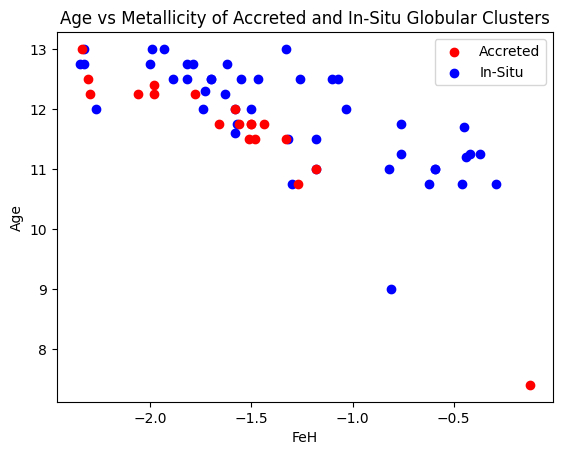

In [118]:

mask = Accreted['ID'].isin(set_accreted)


fig, ax = plt.subplots()


ax.scatter(Accreted['FeH'], Accreted['Age'], color='red', label='Accreted',zorder=2)
ax.scatter(InSitu['FeH'], InSitu['Age'], color='blue', label='In-Situ',zorder=1)

# Add labels and legend
ax.set_xlabel('FeH')
ax.set_ylabel('Age')
ax.legend()
ax.set_title('Age vs Metallicity of Accreted and In-Situ Globular Clusters')

plt.show()


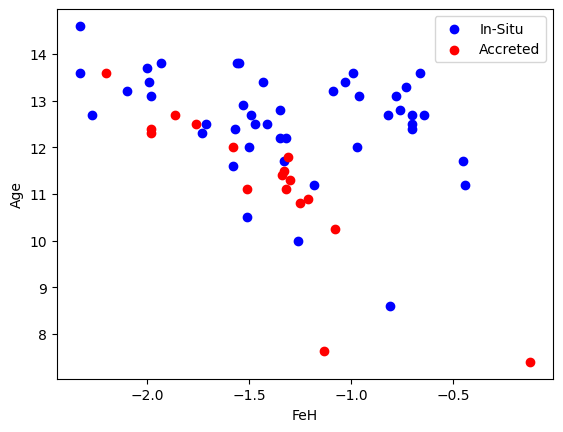

In [115]:
# Create a mask for IDs in int_accreted
mask = Krause['Object'].isin(set_accreted)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot in situ stars (blue)
ax.scatter(Krause.loc[~mask, 'FeH'], Krause.loc[~mask, 'Age'], color='blue', label='In-Situ')

# Plot accreted stars (red)
ax.scatter(Krause.loc[mask, 'FeH'], Krause.loc[mask, 'Age'], color='red', label='Accreted')

# Add labels and legend
ax.set_xlabel('FeH')
ax.set_ylabel('Age')
ax.legend()

plt.show()


#Krause.plot(kind = 'scatter', x ='FeH',y='Age')

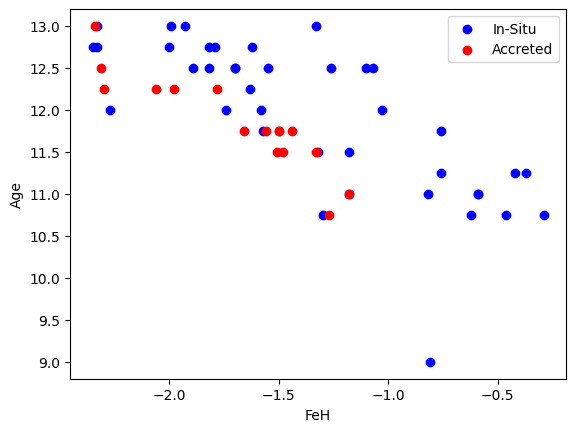

In [113]:
# Create a mask for IDs in int_accreted
mask = VandenBerg['#NGC'].isin(set_accreted)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot non-accreted stars (blue)
ax.scatter(VandenBerg.loc[~mask,'FeH'], VandenBerg.loc[~mask, 'Age'],color='blue', label='In-Situ')

# Plot accreted stars (red)
ax.scatter(VandenBerg.loc[mask, 'FeH'], VandenBerg.loc[mask, 'Age'], color='red', label='Accreted')

# Add labels and legend
ax.set_xlabel('FeH')
ax.set_ylabel('Age')
ax.legend()


#VandenBerg.plot(kind = 'scatter', x ='FeH',y='Age')